<a href="https://colab.research.google.com/github/bluesparrow09/ESP32-Power-Saving-Lab/blob/main/final_project_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 载入 MFCC 和 STFT 特征
X_mfcc = np.load("X_mfcc.npy")  # (1440, 40)
X_stft = np.load("X_stft.npy")  # (1440, 1025)
y = np.load("y_labels.npy")  # (1440,)

# 确保标签是整数格式
y = y.astype(int)

# 组合 MFCC 和 STFT 作为输入
X = np.concatenate([X_mfcc, X_stft], axis=1)  # 结合两种特征

# 归一化特征
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"训练集: {X_train.shape}, 测试集: {X_test.shape}")


训练集: (1152, 1065), 测试集: (288, 1065)


# 2. SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 训练 SVM 模型
svm_model = SVC(kernel='rbf', C=10, gamma='scale')  # 你可以尝试 C=1, C=100 等不同值
svm_model.fit(X_train, y_train)

# 预测
y_pred = svm_model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.2f}")

# 生成分类报告（Precision, Recall, F1-score）
report = classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in np.unique(y_test)])
print(report)


SVM Accuracy: 0.49
              precision    recall  f1-score   support

     Class 1       0.33      0.18      0.23        17
     Class 2       0.61      0.69      0.65        45
     Class 3       0.42      0.41      0.42        34
     Class 4       0.30      0.43      0.35        35
     Class 5       0.58      0.50      0.54        38
     Class 6       0.67      0.50      0.57        48
     Class 7       0.46      0.49      0.47        37
     Class 8       0.49      0.53      0.51        34

    accuracy                           0.49       288
   macro avg       0.48      0.47      0.47       288
weighted avg       0.51      0.49      0.49       288



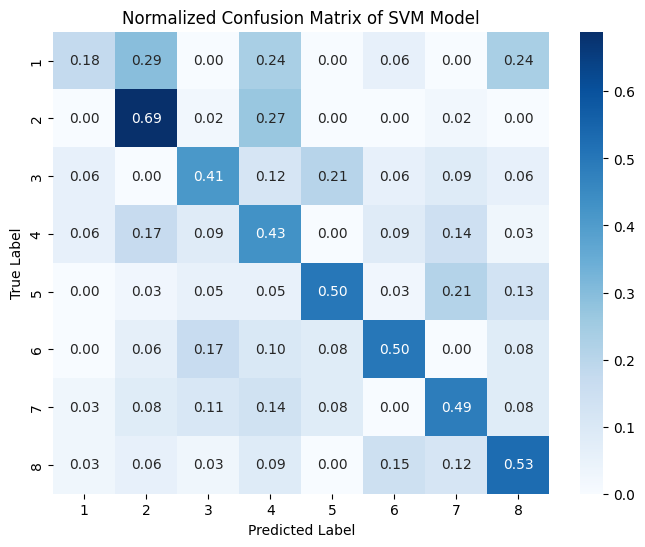

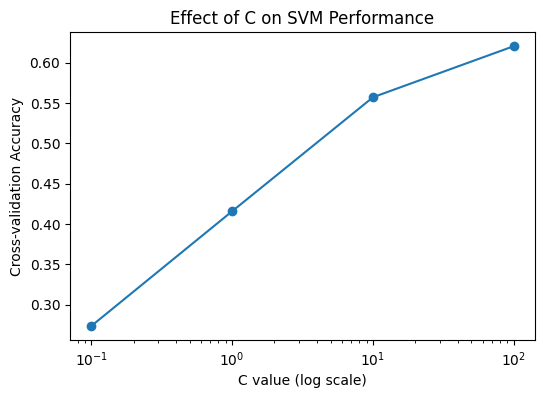

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 绘制混淆矩阵
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix of SVM Model")
plt.show()

# SVM 超参数 C 值影响分析
C_values = [0.1, 1, 10, 100]
accuracies = []

for C in C_values:
    svm_model = SVC(kernel='rbf', C=C, gamma='scale')
    scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='accuracy')
    accuracies.append(scores.mean())

# 可视化不同 C 值对 SVM 准确率的影响
plt.figure(figsize=(6,4))
plt.plot(C_values, accuracies, marker='o')
plt.xscale("log")
plt.xlabel("C value (log scale)")
plt.ylabel("Cross-validation Accuracy")
plt.title("Effect of C on SVM Performance")
plt.show()

# 3. CNN-LSTM

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 载入数据
X_mfcc = np.load("X_mfcc.npy")  # (1440, 40)
X_stft = np.load("X_stft.npy")  # (1440, 1025)
y = np.load("y_labels.npy")  # (1440,)

# 确保标签是整数格式
y = y.astype(int)

# 组合 MFCC 和 STFT 作为输入
X = np.concatenate([X_mfcc, X_stft], axis=1)  # 结合两种特征

# 归一化特征
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 确保 X 形状适配 CNN-LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)  # (1440, 1065, 1)

# 确保 y 从 0 开始
y -= np.min(y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"训练集: {X_train.shape}, 测试集: {X_test.shape}")


训练集: (1152, 1065, 1), 测试集: (288, 1065, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization

num_classes = len(np.unique(y_train))  # 计算真实类别数

# 构建优化的 CNN-LSTM
model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', padding='same', input_shape=(X.shape[1], 1)),
    BatchNormalization(),
    LSTM(128, return_sequences=True),  # 第一层 LSTM
    Dropout(0.3),  # 防止过拟合
    LSTM(64, return_sequences=False),  # 第二层 LSTM
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1065, 64)            │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1065, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1065, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1065, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,216 (618.03 KB)

 Trainable params: 158,088 (617.53 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.1856 - loss: 2.0234 - val_accuracy: 0.2424 - val_loss: 1.9926
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.2229 - loss: 1.9177 - val_accuracy: 0.2424 - val_loss: 1.9435
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 89s 5s/step - accuracy: 0.2594 - loss: 1.8482 - val_accuracy: 0.2294 - val_loss: 1.9458
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.2589 - loss: 1.8739 - val_accuracy: 0.2381 - val_loss: 1.9168
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.2599 - loss: 1.8330 - val_accuracy: 0.2338 - val_loss: 1.9198
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.2856 - loss: 1.8258 - val_accuracy: 0.2078 - val_loss: 1.9179
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.2341 - loss: 1.8530 - val_accuracy: 0.2554 - val_loss: 1.9110
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.2751 - loss: 1.7964 - val_accuracy: 0.2424 - v

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
CNN-LSTM Accuracy: 0.24
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.39      0.71      0.50        45
           2       0.00      0.00      0.00        34
           3       0.19      0.14      0.16        35
           4       0.22      0.29      0.25        38
           5       0.20      0.19      0.19        48
           6       0.17      0.35      0.23        37
           7       0.00      0.00      0.00        34

    accuracy                           0.24       288
   macro avg       0.14      0.21      0.17       288
weighted avg       0.17      0.24      0.19       288



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


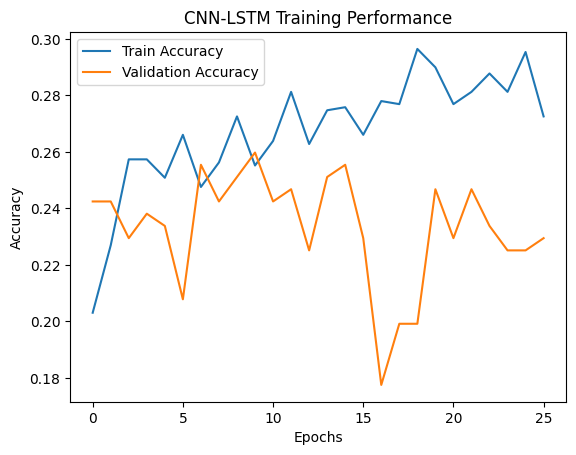

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# 早停策略（耐心度提高到 10）
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 开始训练
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# 保存模型
model.save("cnn_lstm_model.h5")

# 评估模型
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"CNN-LSTM Accuracy: {accuracy:.2f}")

# 打印分类报告
print(classification_report(y_test, y_pred))

# 可视化训练曲线
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN-LSTM Training Performance")
plt.show()


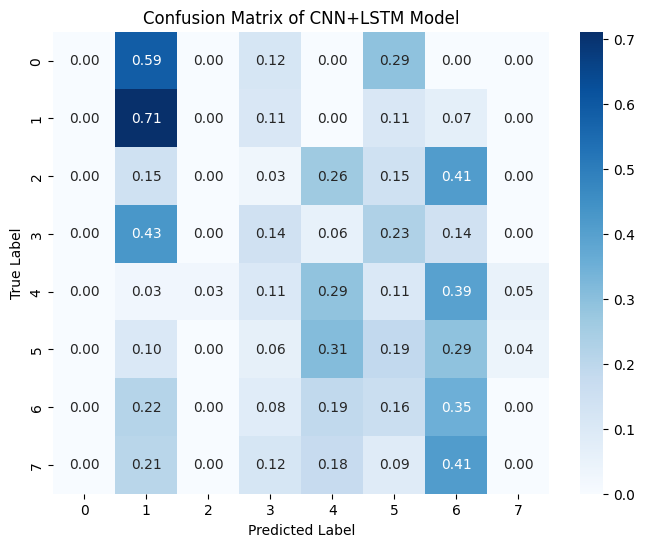

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 生成 Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# 归一化（按真实类别归一化）
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 可视化
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix of CNN+LSTM Model")
plt.show()


# 4. Ablation Study


In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load features
X_mfcc = np.load("X_mfcc.npy")   # (1440, 40)
X_stft = np.load("X_stft.npy")   # (1440, 1025)
y = np.load("y_labels.npy").astype(int)  # (1440,)

# Feature combinations
feature_sets = {
    "MFCC only": X_mfcc,
    "STFT only": X_stft,
    "MFCC + STFT": np.concatenate([X_mfcc, X_stft], axis=1)
}

# Train and evaluate each feature set
for name, X in feature_sets.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = SVC(kernel="rbf", C=10)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")


MFCC only Accuracy: 0.3438
STFT only Accuracy: 0.4132
MFCC + STFT Accuracy: 0.3403


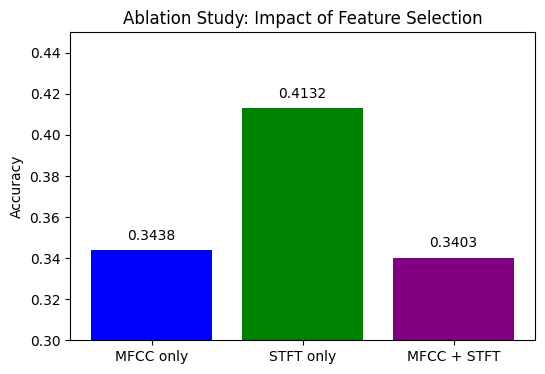

In [ ]:
# Re-import necessary libraries since the execution state was reset
import matplotlib.pyplot as plt

# Feature sets and their corresponding accuracy values
feature_sets = ["MFCC only", "STFT only", "MFCC + STFT"]
accuracies = [0.3438, 0.4132, 0.3403]

# Create bar chart
plt.figure(figsize=(6, 4))
plt.bar(feature_sets, accuracies, color=['blue', 'green', 'purple'])

# Labels and title
plt.ylabel("Accuracy")
plt.title("Ablation Study: Impact of Feature Selection")
plt.ylim(0.3, 0.45)  # Set y-axis limits for better comparison

# Annotate bars with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.4f}", ha='center', fontsize=10)

# Show plot
plt.show()
